In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_1dim.npz')                  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['h'])) 

number of training samples:  1000


In [7]:
cosmo_params = np.zeros((len(train_params['h']), 1))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
#cosmo_params[:, 3] = train_params['ns']
#cosmo_params[:, 4] = train_params['z']
#cosmo_params[:, 5] = train_params['lnAs']
#cosmo_params[:, 6] = train_params['w']

[0.]


In [8]:
print(cosmo_params[0])
print(cosmo_params[199])

[0.81331331]
[0.99249249]


In [9]:
def camb_cosmo(i):
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*cosmo_params[i, 0], ombh2=0.022, omch2=0.122)
    pars.InitPower.set_params(As = 2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
    s8 = np.array(results.get_sigma8())      
    # s8 is the amplitude of matter fluctuations, i.e. in term of the average r.m.s fluctuation in a sphere of 8h^{−1}Mpc
    

    
#     plt.figure(figsize = (10,8))
#     plt.loglog(camb_kh, camb_pk[0], 'r')
#     #plt.plot(, r_array, 'ro')
#     plt.title('Matter Power Spectrum at z=0.0')
#     plt.rc('axes', labelsize=18)
#     plt.rc('axes', titlesize=16)
#     plt.rcParams['xtick.labelsize']=14
#     plt.rcParams['ytick.labelsize']=14
#     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#     #plt.legend(['linear'], loc='lower left', fontsize=14);
#     plt.grid(alpha=0.2)
#     plt.tick_params(top=True,right=True, length=6)
#     plt.show()
    
    return camb_kh, camb_pk[0] 
    
    
cosmo_func = camb_cosmo(0)                                                   #calculates the m.p.s of 1st sample out of 200
#print(cosmo_func[1])
#print(pk[0])

Epoch 1/100
14/14 - 0s - loss: 0.9608 - 364ms/epoch - 26ms/step
Epoch 2/100
14/14 - 0s - loss: 0.9442 - 12ms/epoch - 855us/step
Epoch 3/100
14/14 - 0s - loss: 0.9095 - 17ms/epoch - 1ms/step
Epoch 4/100
14/14 - 0s - loss: 0.8454 - 17ms/epoch - 1ms/step
Epoch 5/100
14/14 - 0s - loss: 0.7381 - 17ms/epoch - 1ms/step
Epoch 6/100
14/14 - 0s - loss: 0.5749 - 17ms/epoch - 1ms/step
Epoch 7/100
14/14 - 0s - loss: 0.4047 - 14ms/epoch - 998us/step
Epoch 8/100
14/14 - 0s - loss: 0.2656 - 13ms/epoch - 925us/step
Epoch 9/100
14/14 - 0s - loss: 0.1810 - 14ms/epoch - 996us/step
Epoch 10/100
14/14 - 0s - loss: 0.1355 - 14ms/epoch - 997us/step
Epoch 11/100
14/14 - 0s - loss: 0.1161 - 14ms/epoch - 997us/step
Epoch 12/100
14/14 - 0s - loss: 0.1056 - 14ms/epoch - 997us/step
Epoch 13/100
14/14 - 0s - loss: 0.0974 - 14ms/epoch - 997us/step
Epoch 14/100
14/14 - 0s - loss: 0.0910 - 14ms/epoch - 997us/step
Epoch 15/100
14/14 - 0s - loss: 0.0862 - 14ms/epoch - 997us/step
Epoch 16/100
14/14 - 0s - loss: 0.0813 - 1

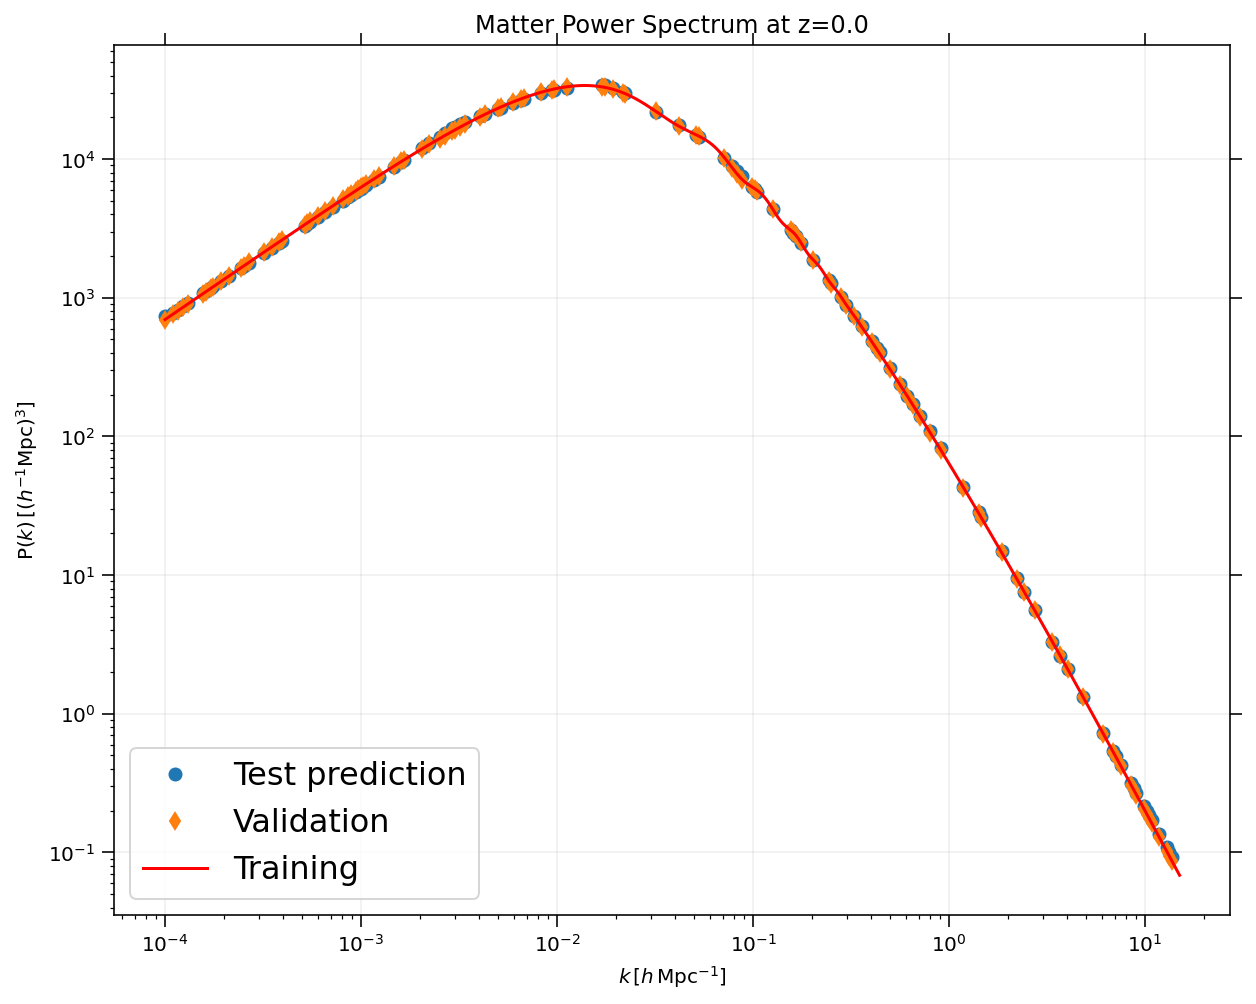

In [10]:
## TESTING (ANN for computing many cosmologies (for n_samples)):

# Generate power spectra:
cosmo_func = camb_cosmo(0)
    
train_k = cosmo_func[0]                                                             
train_pk = cosmo_func[1]    

# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

# Split the data into training and testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss = 'mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)


# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.",  markersize=12)         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(train_k, train_pk, 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

# #residual plot
# ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
# ax[1].loglog(train_k, ((prediction_train-train_pk)/train_pk), 'r', linestyle="dashdot")  #
# #plt.loglog(kh, pk[0], 'C0', linestyle="dashed")   
# #ax[1].loglog(kh, ((y_test-train_pk)/train_pk), 'C0')
# ax[1].set_yscale('linear')
# fig.tight_layout()
# plt.savefig('power_spectrum_H0.pdf')
# plt.show()

In [11]:
print(np.shape(train_k))
print(np.shape(train_pk))
print(np.shape(prediction_train))

(400,)
(400,)
(280, 1)


In [12]:
len(train_params['h'])

1000

In [13]:
#%%time
## Training input params:
h = cosmo_params[:, 0]

In [14]:
# np.shape(pk_matrix)                          #1400x400: 1400 cosmologies/n_samples, each with 400 pts/elements in array
# print(pk_matrix[199])

In [15]:
with open('pk_data_1dim.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [16]:
# Training input params and output param:

train_H0 = 100*h                               #1x400                     # np.arrays, sizes len(train_params['h'])
train_pk = pk_matrix                           #400x1400                   # don't need kh, stays the same

In [17]:
input_params = np.vstack([train_H0])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #800x3
#print(output_data)

(1000, 1)
(1000, 400)
            H0
0    81.331331
1    81.731732
2    61.261261
3    80.980981
4    59.759760
..         ...
995  84.284284
996  97.347347
997  77.477477
998  80.380380
999  95.295295

[1000 rows x 1 columns]


In [18]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 1120x1
print(X_train.shape[1])     # 1

(800, 1)
1


In [19]:
print(X_train)

            H0
29   70.120120
535  72.472472
695  64.364364
557  76.376376
836  94.994995
..         ...
106  61.111111
270  89.089089
860  72.272272
435  93.293293
102  93.243243

[800 rows x 1 columns]


In [20]:
# Standardising:

train_input_data = StandardScaler()
test_input_data = StandardScaler()

scaled_X_train = train_input_data.fit(X_train)
scaled_X_test = test_input_data.fit(X_test)

# # Generating the standardized values of X_train, X_test:
# X_train1 = scaled_X_train.transform(X_train)                  ##############3
# X_test1 = scaled_X_test.transform(X_test)                     #########3#####

X_train1 = X_train
X_test1 = X_test

In [21]:
print("y_test shape:", np.shape(y_test))
print("X_train1 shape:", np.shape(X_train1))
print("X_test1 shape:",np.shape(X_test1))
print("X_train:", X_train1)
print("X_test:", X_test1)

y_test shape: (200, 400)
X_train1 shape: (800, 1)
X_test1 shape: (200, 1)
X_train:             H0
29   70.120120
535  72.472472
695  64.364364
557  76.376376
836  94.994995
..         ...
106  61.111111
270  89.089089
860  72.272272
435  93.293293
102  93.243243

[800 rows x 1 columns]
X_test:             H0
521  52.002002
737  65.815816
740  65.165165
660  50.600601
411  61.461461
..         ...
408  60.610611
332  79.679680
208  77.777778
613  95.045045
78   80.880881

[200 rows x 1 columns]


In [37]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=250, input_dim=X_train1.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))
 
# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

tf_model.add(Dense(400, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=0.05)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
tf_model.fit(X_train1, y_train, batch_size = 60, epochs = 780, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test1))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print(np.shape(100-MAPE))
#print('Accuracy:', 100-MAPE)

Epoch 1/780
14/14 - 0s - loss: 59937220.0000 - 295ms/epoch - 21ms/step
Epoch 2/780
14/14 - 0s - loss: 10792166.0000 - 52ms/epoch - 4ms/step
Epoch 3/780
14/14 - 0s - loss: 8037179.0000 - 38ms/epoch - 3ms/step
Epoch 4/780
14/14 - 0s - loss: 6797421.5000 - 35ms/epoch - 2ms/step
Epoch 5/780
14/14 - 0s - loss: 6464718.0000 - 45ms/epoch - 3ms/step
Epoch 6/780
14/14 - 0s - loss: 5699915.5000 - 36ms/epoch - 3ms/step
Epoch 7/780
14/14 - 0s - loss: 5411456.5000 - 33ms/epoch - 2ms/step
Epoch 8/780
14/14 - 0s - loss: 5932954.0000 - 35ms/epoch - 2ms/step
Epoch 9/780
14/14 - 0s - loss: 5527259.0000 - 31ms/epoch - 2ms/step
Epoch 10/780
14/14 - 0s - loss: 3821512.7500 - 37ms/epoch - 3ms/step
Epoch 11/780
14/14 - 0s - loss: 2429053.0000 - 33ms/epoch - 2ms/step
Epoch 12/780
14/14 - 0s - loss: 4020714.5000 - 31ms/epoch - 2ms/step
Epoch 13/780
14/14 - 0s - loss: 2881264.7500 - 31ms/epoch - 2ms/step
Epoch 14/780
14/14 - 0s - loss: 2065460.7500 - 31ms/epoch - 2ms/step
Epoch 15/780
14/14 - 0s - loss: 2269073

Epoch 120/780
14/14 - 0s - loss: 1921687.3750 - 40ms/epoch - 3ms/step
Epoch 121/780
14/14 - 0s - loss: 1554183.6250 - 38ms/epoch - 3ms/step
Epoch 122/780
14/14 - 0s - loss: 1478334.3750 - 35ms/epoch - 2ms/step
Epoch 123/780
14/14 - 0s - loss: 1457805.8750 - 34ms/epoch - 2ms/step
Epoch 124/780
14/14 - 0s - loss: 1380498.1250 - 34ms/epoch - 2ms/step
Epoch 125/780
14/14 - 0s - loss: 1267263.3750 - 38ms/epoch - 3ms/step
Epoch 126/780
14/14 - 0s - loss: 1735764.1250 - 38ms/epoch - 3ms/step
Epoch 127/780
14/14 - 0s - loss: 1406711.5000 - 40ms/epoch - 3ms/step
Epoch 128/780
14/14 - 0s - loss: 705946.3125 - 42ms/epoch - 3ms/step
Epoch 129/780
14/14 - 0s - loss: 1251693.1250 - 39ms/epoch - 3ms/step
Epoch 130/780
14/14 - 0s - loss: 2315162.5000 - 41ms/epoch - 3ms/step
Epoch 131/780
14/14 - 0s - loss: 1423840.1250 - 40ms/epoch - 3ms/step
Epoch 132/780
14/14 - 0s - loss: 576776.2500 - 40ms/epoch - 3ms/step
Epoch 133/780
14/14 - 0s - loss: 212268.5938 - 39ms/epoch - 3ms/step
Epoch 134/780
14/14 - 0

Epoch 240/780
14/14 - 0s - loss: 26227.5898 - 33ms/epoch - 2ms/step
Epoch 241/780
14/14 - 0s - loss: 73573.1719 - 33ms/epoch - 2ms/step
Epoch 242/780
14/14 - 0s - loss: 69219.8125 - 33ms/epoch - 2ms/step
Epoch 243/780
14/14 - 0s - loss: 184890.2656 - 33ms/epoch - 2ms/step
Epoch 244/780
14/14 - 0s - loss: 338524.5938 - 33ms/epoch - 2ms/step
Epoch 245/780
14/14 - 0s - loss: 222542.3594 - 33ms/epoch - 2ms/step
Epoch 246/780
14/14 - 0s - loss: 113371.5234 - 33ms/epoch - 2ms/step
Epoch 247/780
14/14 - 0s - loss: 99441.3594 - 35ms/epoch - 2ms/step
Epoch 248/780
14/14 - 0s - loss: 74611.5391 - 34ms/epoch - 2ms/step
Epoch 249/780
14/14 - 0s - loss: 112261.2812 - 31ms/epoch - 2ms/step
Epoch 250/780
14/14 - 0s - loss: 130275.0781 - 33ms/epoch - 2ms/step
Epoch 251/780
14/14 - 0s - loss: 35066.5312 - 31ms/epoch - 2ms/step
Epoch 252/780
14/14 - 0s - loss: 44501.2148 - 32ms/epoch - 2ms/step
Epoch 253/780
14/14 - 0s - loss: 33043.7188 - 31ms/epoch - 2ms/step
Epoch 254/780
14/14 - 0s - loss: 27337.457

Epoch 360/780
14/14 - 0s - loss: 1585480.7500 - 34ms/epoch - 2ms/step
Epoch 361/780
14/14 - 0s - loss: 513656.8750 - 32ms/epoch - 2ms/step
Epoch 362/780
14/14 - 0s - loss: 339718.1250 - 33ms/epoch - 2ms/step
Epoch 363/780
14/14 - 0s - loss: 163444.6250 - 33ms/epoch - 2ms/step
Epoch 364/780
14/14 - 0s - loss: 45672.2812 - 32ms/epoch - 2ms/step
Epoch 365/780
14/14 - 0s - loss: 44852.5000 - 30ms/epoch - 2ms/step
Epoch 366/780
14/14 - 0s - loss: 140478.2812 - 34ms/epoch - 2ms/step
Epoch 367/780
14/14 - 0s - loss: 106181.5391 - 32ms/epoch - 2ms/step
Epoch 368/780
14/14 - 0s - loss: 32215.0645 - 33ms/epoch - 2ms/step
Epoch 369/780
14/14 - 0s - loss: 33166.8164 - 33ms/epoch - 2ms/step
Epoch 370/780
14/14 - 0s - loss: 57571.4844 - 32ms/epoch - 2ms/step
Epoch 371/780
14/14 - 0s - loss: 36851.9844 - 35ms/epoch - 2ms/step
Epoch 372/780
14/14 - 0s - loss: 36509.8164 - 33ms/epoch - 2ms/step
Epoch 373/780
14/14 - 0s - loss: 28183.1270 - 33ms/epoch - 2ms/step
Epoch 374/780
14/14 - 0s - loss: 29503.94

14/14 - 0s - loss: 218909.3125 - 33ms/epoch - 2ms/step
Epoch 481/780
14/14 - 0s - loss: 241338.5000 - 33ms/epoch - 2ms/step
Epoch 482/780
14/14 - 0s - loss: 841587.1250 - 31ms/epoch - 2ms/step
Epoch 483/780
14/14 - 0s - loss: 222088.0156 - 32ms/epoch - 2ms/step
Epoch 484/780
14/14 - 0s - loss: 335176.1562 - 31ms/epoch - 2ms/step
Epoch 485/780
14/14 - 0s - loss: 222811.0781 - 33ms/epoch - 2ms/step
Epoch 486/780
14/14 - 0s - loss: 165000.2344 - 33ms/epoch - 2ms/step
Epoch 487/780
14/14 - 0s - loss: 48314.7383 - 31ms/epoch - 2ms/step
Epoch 488/780
14/14 - 0s - loss: 60179.1484 - 33ms/epoch - 2ms/step
Epoch 489/780
14/14 - 0s - loss: 133276.2500 - 35ms/epoch - 2ms/step
Epoch 490/780
14/14 - 0s - loss: 48854.4531 - 31ms/epoch - 2ms/step
Epoch 491/780
14/14 - 0s - loss: 27584.9375 - 33ms/epoch - 2ms/step
Epoch 492/780
14/14 - 0s - loss: 18919.7559 - 30ms/epoch - 2ms/step
Epoch 493/780
14/14 - 0s - loss: 14387.2275 - 33ms/epoch - 2ms/step
Epoch 494/780
14/14 - 0s - loss: 13494.3779 - 33ms/epo

14/14 - 0s - loss: 7403.3608 - 32ms/epoch - 2ms/step
Epoch 602/780
14/14 - 0s - loss: 5765.5977 - 33ms/epoch - 2ms/step
Epoch 603/780
14/14 - 0s - loss: 6631.2026 - 31ms/epoch - 2ms/step
Epoch 604/780
14/14 - 0s - loss: 7995.6855 - 33ms/epoch - 2ms/step
Epoch 605/780
14/14 - 0s - loss: 34545.2383 - 31ms/epoch - 2ms/step
Epoch 606/780
14/14 - 0s - loss: 276525.6875 - 34ms/epoch - 2ms/step
Epoch 607/780
14/14 - 0s - loss: 252635.8750 - 42ms/epoch - 3ms/step
Epoch 608/780
14/14 - 0s - loss: 362948.9062 - 31ms/epoch - 2ms/step
Epoch 609/780
14/14 - 0s - loss: 98560.3125 - 35ms/epoch - 2ms/step
Epoch 610/780
14/14 - 0s - loss: 31785.5469 - 34ms/epoch - 2ms/step
Epoch 611/780
14/14 - 0s - loss: 11743.9053 - 33ms/epoch - 2ms/step
Epoch 612/780
14/14 - 0s - loss: 21384.2578 - 34ms/epoch - 2ms/step
Epoch 613/780
14/14 - 0s - loss: 64515.4805 - 33ms/epoch - 2ms/step
Epoch 614/780
14/14 - 0s - loss: 9571.7109 - 33ms/epoch - 2ms/step
Epoch 615/780
14/14 - 0s - loss: 13366.3262 - 33ms/epoch - 2ms/s

14/14 - 0s - loss: 90091.1797 - 37ms/epoch - 3ms/step
Epoch 723/780
14/14 - 0s - loss: 51253.9648 - 41ms/epoch - 3ms/step
Epoch 724/780
14/14 - 0s - loss: 27593.8926 - 37ms/epoch - 3ms/step
Epoch 725/780
14/14 - 0s - loss: 11606.5078 - 42ms/epoch - 3ms/step
Epoch 726/780
14/14 - 0s - loss: 17487.3066 - 36ms/epoch - 3ms/step
Epoch 727/780
14/14 - 0s - loss: 26200.5723 - 37ms/epoch - 3ms/step
Epoch 728/780
14/14 - 0s - loss: 11334.7217 - 35ms/epoch - 2ms/step
Epoch 729/780
14/14 - 0s - loss: 4800.3574 - 37ms/epoch - 3ms/step
Epoch 730/780
14/14 - 0s - loss: 33550.6016 - 35ms/epoch - 2ms/step
Epoch 731/780
14/14 - 0s - loss: 27931.0605 - 32ms/epoch - 2ms/step
Epoch 732/780
14/14 - 0s - loss: 8445.9863 - 35ms/epoch - 2ms/step
Epoch 733/780
14/14 - 0s - loss: 12620.9248 - 33ms/epoch - 2ms/step
Epoch 734/780
14/14 - 0s - loss: 25477.0352 - 34ms/epoch - 2ms/step
Epoch 735/780
14/14 - 0s - loss: 9406.8232 - 32ms/epoch - 2ms/step
Epoch 736/780
14/14 - 0s - loss: 25573.1016 - 34ms/epoch - 2ms/st

c:\program files\python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


H0: 67


parameter:  ['67']


H0: 67.0


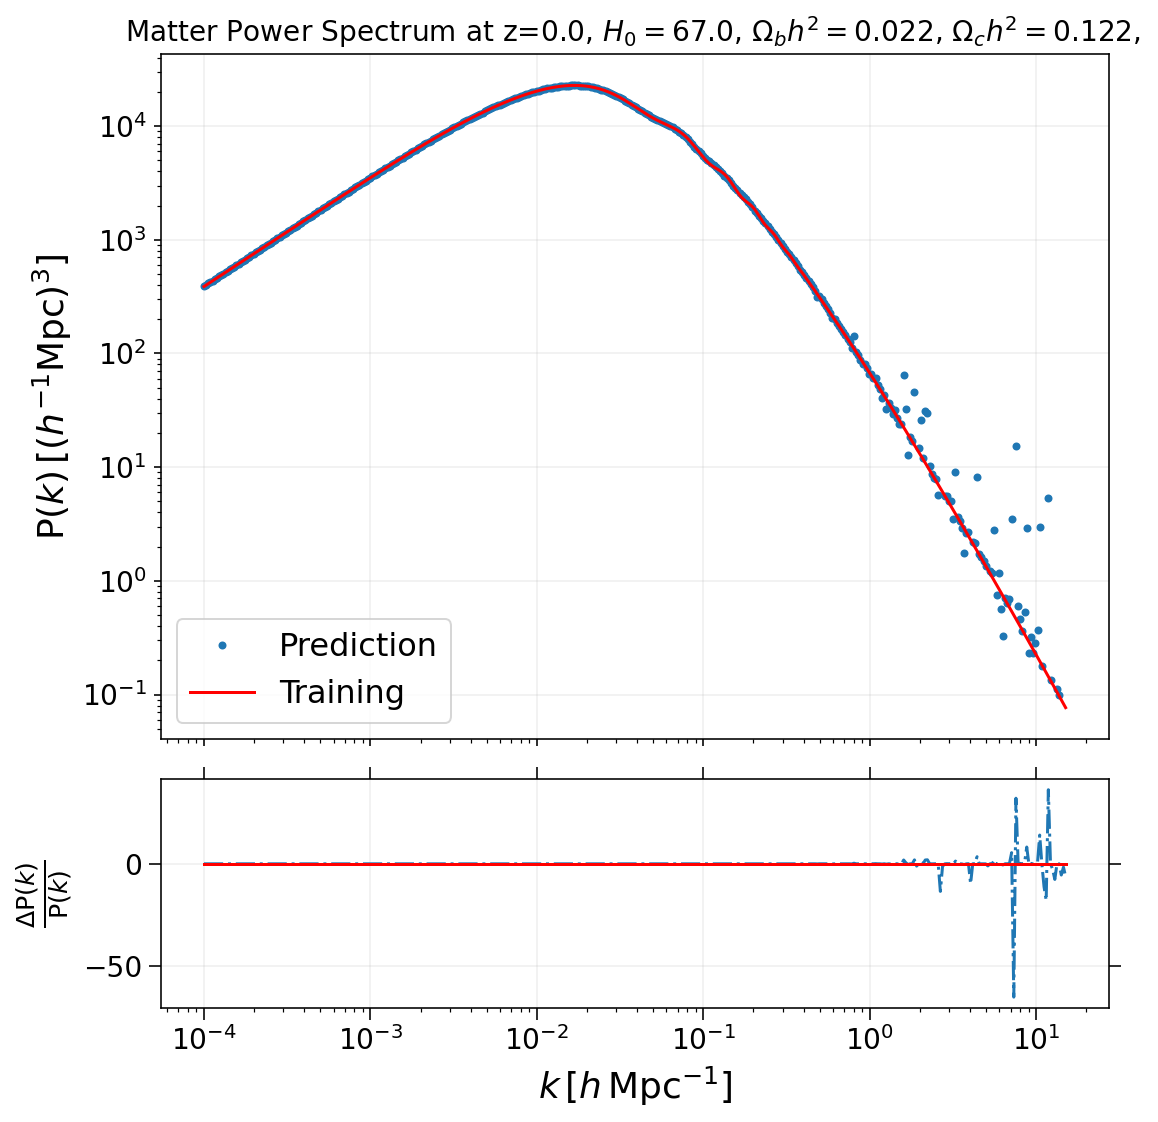

In [38]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to int type
    for i in range(len(user_list)):
        # convert each item to int type
        user_list[i] = float(user_list[i])
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, 1))
    pred_pk = tf_model.predict(cosmo_arr)
    
    def camb_cosmo2():
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=0.022, omch2=0.122)
        pars.InitPower.set_params(As = 2e-9, ns=0.965)
        pars.set_matter_power(redshifts=[0.0], kmax=10.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
        s8 = np.array(results.get_sigma8())
    
        return camb_kh, camb_pk[0] 
    
    generate_camb_ps = camb_cosmo2()
#     temp = generate_camb_ps

    print('H0:' , cosmo_arr[0][0])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(generate_camb_ps[0], pred_pk[0], "C0.")                                    
    #plt.loglog(X_test, y_test, "C1d")
    ax[0].loglog(generate_camb_ps[0], generate_camb_ps[1], 'r')                              
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = 0.022$, ' + '$\Omega_{c}h^{2} = 0.122$, ', fontsize = 14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
#     #pred_pk needs to be sorted:
#     zipped_lists = zip(temp, pred_pk)
#     sorted_pairs = sorted(zipped_lists)

#     tuples = zip(*sorted_pairs)
#     temp, pred_pk = [list(tuple) for tuple in  tuples]
#     temp = np.array(temp)
#     pred_pk = np.array(pred_pk)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].loglog(generate_camb_ps[0], ((pred_pk[0]-generate_camb_ps[1])/generate_camb_ps[1]), 'C0', linestyle="dashdot") 
    ax[1].loglog(generate_camb_ps[0], ((generate_camb_ps[1]-generate_camb_ps[1])/generate_camb_ps[1]), 'r')
    ax[1].set_yscale('linear')
    fig.tight_layout()
    #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    
    

Generate = calc_cosmo()